# This notebook is about how to prepare a grammar prediction model for a voice data. It includes all the necessary code, illustrations for a clear unders


#### first let's install the necessary libraries

<u>***Librosa is a python package which is used for audio and music signal processing***<u>

In [21]:
!pip install librosa

DEPRECATION: pytorch-lightning 1.8.1 has a non-standard dependency specifier torch>=1.9.*. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pytorch-lightning or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063


In [5]:
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import IPython.display as ipd
import os
import numpy as np
from tqdm import tqdm

#### this line helps to first listen to a sample voice file. 

In [6]:
from IPython.display import Audio

# Path to an example audio file from the training set
audio_file = "audio_10.wav"

# Play the audio
Audio(audio_file)

#### load the training data using ***pandas*** and view it's columns

In [13]:
data = pd.read_csv('train.csv')

In [13]:
print(data.columns)

Index(['filename', 'label'], dtype='object')


#### Load the train and test data into DataFrames. The head() method helps us to view the first few rows of data, giving us a quick glance at the data we are working on

In [15]:
import pandas as pd

# Loading the data
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')


print("Train Data:")
print(train_df.head())

#check first few rows

print("\nTest Data:")
print(test_df.head())

Train Data:
         filename  label
0  audio_1261.wav    1.0
1   audio_942.wav    1.5
2  audio_1110.wav    1.5
3  audio_1024.wav    1.5
4   audio_538.wav    2.0

Test Data:
         filename
0   audio_706.wav
1   audio_800.wav
2    audio_68.wav
3  audio_1267.wav
4   audio_683.wav


#### Histogram helps in visualising how the grammar scores are distributed on the training dataset. I grouped the scores into 5 intervals. This can help us to understand if the data is balanced or skewed.

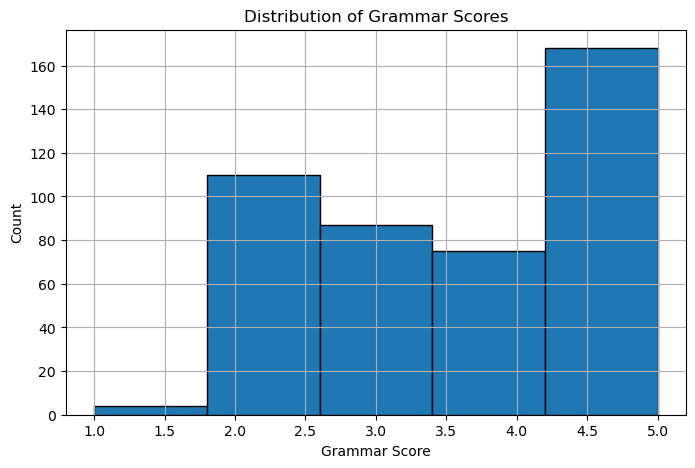

In [8]:
plt.figure(figsize=(8,5))
train_df['label'].hist(bins=5, edgecolor='black')
plt.xlabel("Grammar Score")
plt.ylabel("Count")
plt.title("Distribution of Grammar Scores")
plt.show()

#### *resampy* helps in an efficient audio resampling. *soundfile* can be used to read and write files like .wav files(<u>like how we have .wav files for our dataset</u>). *audioread* is kind of a backend library where it helps to read different audio formats 

In [25]:
!pip install resampy soundfile audioread

DEPRECATION: pytorch-lightning 1.8.1 has a non-standard dependency specifier torch>=1.9.*. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pytorch-lightning or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063


#### this is the step where we extract all the meaningful features from the .wav file. For each voice recording we capture <em>MFCCs(helps in capturing the voice pronunciation patterns)</em>, <em>Chroma(to analyze any tonal variations)</em> etc. All the extracted features are put into a dataframe.

In [9]:
# train audio path
train_audio_path = 'audios_train/'

# train csv path
train_df = pd.read_csv('train.csv')

def extract_features(file_name):
    try:
        audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast')
        
        #feature extraction
        mfccs = np.mean(librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40).T, axis=0)
        chroma = np.mean(librosa.feature.chroma_stft(y=audio, sr=sample_rate).T, axis=0)
        spectral_contrast = np.mean(librosa.feature.spectral_contrast(y=audio, sr=sample_rate).T, axis=0)
        tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(audio), sr=sample_rate).T, axis=0)
        
        return np.hstack([mfccs, chroma, spectral_contrast, tonnetz])
    except Exception as e:
        print(f"Error encountered while parsing file: {file_name} — {e}")
        return np.zeros(40 + 12 + 7 + 6)  # fallback with zeros


features = []
for filename in tqdm(train_df['filename']):
    file_path = os.path.join(train_audio_path, filename)
    features.append(extract_features(file_path))

# converting into a dataframe
feature_names = [f'mfcc_{i}' for i in range(40)] + \
                [f'chroma_{i}' for i in range(12)] + \
                [f'spectral_contrast_{i}' for i in range(7)] + \
                [f'tonnetz_{i}' for i in range(6)]

train_features_df = pd.DataFrame(features, columns=feature_names)

# add the cloumn label
train_features_df['label'] = train_df['label'].values

#save it into a csv file
train_features_df.to_csv('train_features.csv', index=False)

print("✅ Features extracted and saved to train_features.csv")

100%|████████████████████████████████████████████████████████████████████████████████| 444/444 [47:40<00:00,  6.44s/it]

✅ Features extracted and saved to train_features.csv


#### this code helps in verifying if all the files listed in train.csv file exist in the audios_train folder. This helped in preventing any runtime errors like "File Not Found" and helps in extracting features from only valid and available data.

In [16]:

train_df = pd.read_csv('train.csv')
audio_folder = 'audios_train'

#check for any missing or filler files
existing_files = set(os.listdir(audio_folder))
train_df['filename'] = train_df['filename'].astype(str)
train_df = train_df[train_df['filename'].isin(existing_files)].reset_index(drop=True)

print(f'Number of usable training files: {len(train_df)}')
train_df.head()

Number of usable training files: 444


,filename,label
0,audio_1261.wav,1.0
1,audio_942.wav,1.5
2,audio_1110.wav,1.5
3,audio_1024.wav,1.5
4,audio_538.wav,2.0


#### This library helps in performing speech-to-text conversion. 

In [3]:
!pip install SpeechRecognition

DEPRECATION: pytorch-lightning 1.8.1 has a non-standard dependency specifier torch>=1.9.*. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pytorch-lightning or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063


#### the raw .wav files will be converted into text data, which forms the basis for grammar evaluation. These are stored in transcriptions.csv, which can later be used in our model. 

In [17]:
import speech_recognition as sr

audio_folder = 'audios_train'
output_csv = 'transcriptions.csv'


recognizer = sr.Recognizer()
audio_files = [f for f in os.listdir(audio_folder) if f.endswith('.wav')]
results = []
if os.path.exists(output_csv):
    existing_df = pd.read_csv(output_csv)
    processed_files = set(existing_df['filename'])
    results = existing_df.to_dict(orient='records')
    print(f"Resuming from existing file. Already processed: {len(processed_files)} files.")
else:
    processed_files = set()

#transcribe  the audio files
for audio_file in tqdm(audio_files, desc="Transcribing"):
    if audio_file in processed_files:
        continue  #if any files are already done skip them

    audio_path = os.path.join(audio_folder, audio_file)

    with sr.AudioFile(audio_path) as source:
        audio_data = recognizer.record(source)

    try:
        text = recognizer.recognize_google(audio_data)
        print(f"✅ Transcribed {audio_file}")
    except sr.UnknownValueError:
        print(f"❌ Could not understand {audio_file}")
        text = ""
    except sr.RequestError as e:
        print(f"❌ API unavailable or quota exceeded: {e}")
        text = ""

    results.append({'filename': audio_file, 'transcription': text})

    #save the progress of each file so that we won't loose if any unforseen situations arise
    df = pd.DataFrame(results)
    df.to_csv(output_csv, index=False)

print("✅ Transcription completed and saved to", output_csv)

Resuming from existing file. Already processed: 444 files.


Transcribing: 100%|██████████████████████████████████████████████████████████████████████████| 444/444 [00:00<?, ?it/s]

✅ Transcription completed and saved to transcriptions.csv


#### sorts out the filler words like "uh", "umm" etc. this is one of the cleaning step that overall improves the feature quality, feature extraction, grammar error analysis etc.


#### see the few above rows of the transcription data

In [29]:

import re
df = pd.read_csv('transcriptions.csv')

# Define cleaning function
def clean_text(text):
    if not isinstance(text, str):
        return "" 
    # Convert to lowercase
    text = text.lower()
    # Remove filler words
    filler_words = ['uh', 'um', 'you know', 'like', 'so', 'actually']
    pattern = r'\b(?:' + '|'.join(filler_words) + r')\b'
    text = re.sub(pattern, '', text)
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text
df['clean_text'] = df['transcription'].apply(clean_text)

# Save cleaned version
df.to_csv('cleaned_transcriptions.csv', index=False)

print(df.head())

         filename                                      transcription  \
0  audio_1008.wav  school playground is slightly a favourite colo...   
1  audio_1017.wav  the school playground the meditation catch a w...   
2   audio_102.wav  at the markets there is a lot of people saying...   
3  audio_1024.wav  my favourite place is in Andhra Pradesh it is ...   
4  audio_1025.wav  I would like to go the Sanchi for the Sanchi S...   

                                          clean_text  
0  school playground is slightly a favourite colo...  
1  the school playground the meditation catch a w...  
2  at the markets there is a lot of people saying...  
3  my favourite place is in andhra pradesh it is ...  
4  i would to go the sanchi for the sanchi stupa ...  


#### TF-IDF(Term Frequency Inverse Document Frequency) helps in identifying words that are frequent. The words with high T-IDF scores help in contributing fluency and grammatical sophistication. These top words help in building costom features which may influence the grammar score. 

In [11]:
import numpy as np

# Sum up the TF-IDF scores
word_scores = tfidf_df.sum(axis=0).sort_values(ascending=False)

# Show top 20 words
print(word_scores.head(20))

the       78.366240
and       62.875552
my        54.027437
to        53.547392
of        44.151077
is        42.643760
in        39.917008
that      26.006948
with      22.455374
market    22.175079
are       21.879691
it        20.901391
for       20.869283
life      20.784939
very      20.643620
was       20.170695
day       19.982713
people    17.531489
be        17.110594
you       16.744773
dtype: float64


In [62]:
!pip install WordCloud

DEPRECATION: pytorch-lightning 1.8.1 has a non-standard dependency specifier torch>=1.9.*. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pytorch-lightning or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063


In [66]:
!pip install --upgrade threadpoolctl



  Obtaining dependency information for threadpoolctl from https://files.pythonhosted.org/packages/32/d5/f9a850d79b0851d1d4ef6456097579a9005b31fea68726a4ae5f2d82ddd9/threadpoolctl-3.6.0-py3-none-any.whl.metadata
  Attempting uninstall: threadpoolctl
    Found existing installation: threadpoolctl 2.2.0
    Uninstalling threadpoolctl-2.2.0:
      Successfully uninstalled threadpoolctl-2.2.0


DEPRECATION: pytorch-lightning 1.8.1 has a non-standard dependency specifier torch>=1.9.*. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pytorch-lightning or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063


#### With wordcloud we can get a visual representation of the most influential words. 

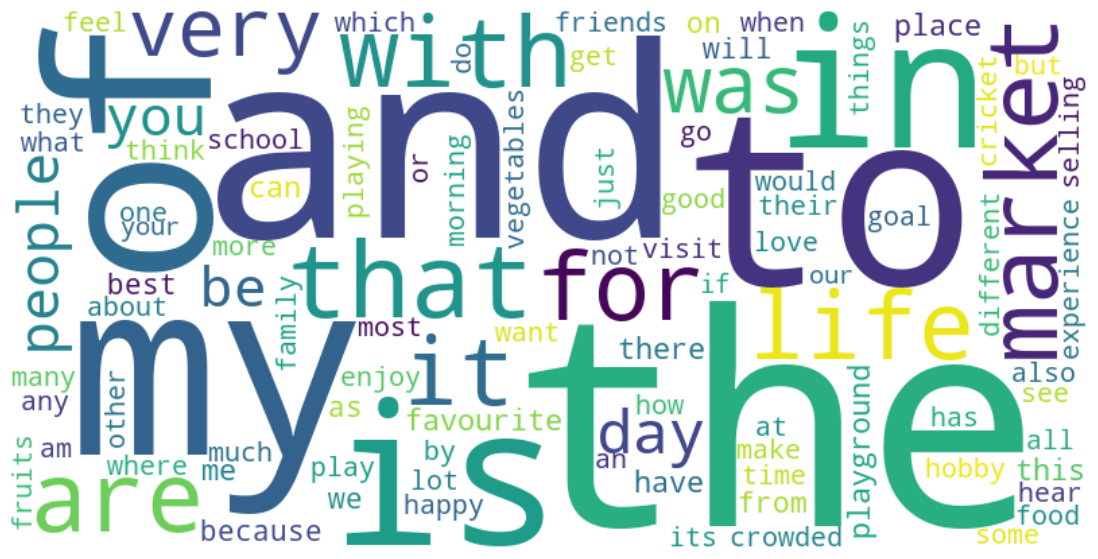

In [56]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_scores)

plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

#### used kmeans to form clusters that can represnt the same words usage ans structure. It can form clusters like complex vocabulary and those with repetitive speech.

#### we have 375 transcriptions with 500 features in total

In [27]:

from sklearn.feature_extraction.text import TfidfVectorizer

# Load the cleaned data
df = pd.read_csv('cleaned_transcriptions.csv')

# Drop NaN and empty strings
df = df.dropna(subset=['clean_text'])
df = df[df['clean_text'].str.strip().astype(bool)]

vectorizer = TfidfVectorizer(max_features=500)
tfidf_matrix = vectorizer.fit_transform(df['clean_text'])

print("TF-IDF feature shape:", tfidf_matrix.shape)

TF-IDF feature shape: (375, 500)


In [29]:
from sklearn.cluster import KMeans

# Define the clusters
num_clusters = 5  
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(tfidf_matrix)

# Assign cluster labels
df['cluster'] = kmeans.labels_

# Save the clustered data
df.to_csv('clustered_transcriptions.csv', index=False)

print(df.head())

         filename                                      transcription  \
0  audio_1008.wav  school playground is slightly a favourite colo...   
1  audio_1017.wav  the school playground the meditation catch a w...   
2   audio_102.wav  at the markets there is a lot of people saying...   
3  audio_1024.wav  my favourite place is in Andhra Pradesh it is ...   
4  audio_1025.wav  I would like to go the Sanchi for the Sanchi S...   

                                          clean_text  cluster  
0  school playground is slightly a favourite colo...        2  
1  the school playground the meditation catch a w...        2  
2  at the markets there is a lot of people saying...        0  
3  my favourite place is in andhra pradesh it is ...        1  
4  i would to go the sanchi for the sanchi stupa ...        1  


C:\Users\prava\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [31]:
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names_out()

for i in range(num_clusters):
    print(f"Cluster {i}:")
    top_terms = [terms[ind] for ind in order_centroids[i, :10]]  # Top 10 terms
    print(", ".join(top_terms))
    print()

Cluster 0:
the, market, people, and, of, in, are, selling, crowded, vegetables

Cluster 1:
place, the, visit, to, favourite, is, in, and, my, of

Cluster 2:
playground, the, play, and, school, of, playing, children, is, cricket

Cluster 3:
my, day, the, and, life, was, best, of, that, in

Cluster 4:
to, my, and, is, the, of, in, that, hobby, life



#### the cluster can be used as features to understnad like which cluster has the higher grammar score. PCA helps us in assuring that the text processing and vectorization successfully captures meaningful language traits. 

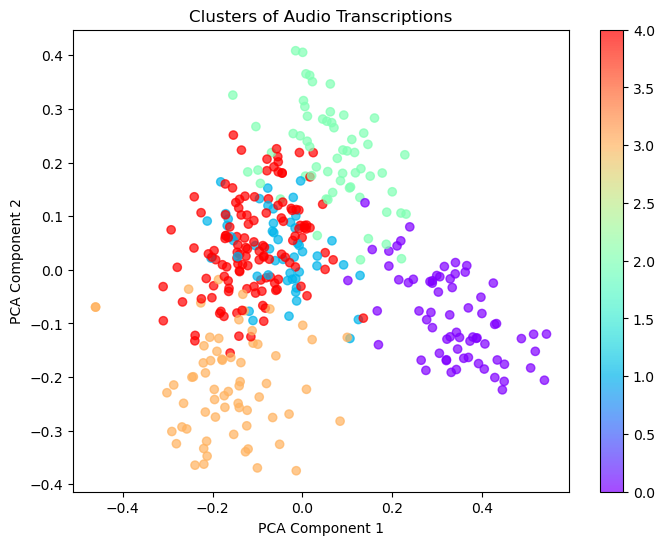

In [33]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Reduce dimensions to 2D for visualization
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(tfidf_matrix.toarray())

plt.figure(figsize=(8, 6))
scatter = plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=df['cluster'], cmap='rainbow', alpha=0.7)
plt.title('Clusters of Audio Transcriptions')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(scatter)
plt.show()

In [92]:
test_df = pd.read_csv('test.csv')
train_df = pd.read_csv('train.csv')

#### here we combine severak features like MCCs, Chroma, Spectral Contrast and Tonnetz. Each audio file will result in a 65 dimensional vector. 

In [94]:
def extract_features(file_name):
    try:
        audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast')
        
        # Extract features
        mfccs = np.mean(librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40).T, axis=0)
        chroma = np.mean(librosa.feature.chroma_stft(y=audio, sr=sample_rate).T, axis=0)
        spectral_contrast = np.mean(librosa.feature.spectral_contrast(y=audio, sr=sample_rate).T, axis=0)
        tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(audio), sr=sample_rate).T, axis=0)
        
        return np.hstack([mfccs, chroma, spectral_contrast, tonnetz])
    except Exception as e:
        print(f"Error processing {file_name}: {e}")
        return np.zeros(40 + 12 + 7 + 6)  # fallback to zeros

# For the train data
train_features = [extract_features(os.path.join('audios_train', f)) for f in train_df['filename']]
train_features = np.array(train_features)

# For the test data
test_features = [extract_features(os.path.join('audios_test', f)) for f in test_df['filename']]
test_features = np.array(test_features)

print("Train features shape:", train_features.shape)
print("Test features shape:", test_features.shape)

Train features shape: (444, 65)
Test features shape: (195, 65)


#### we extracted numerical representations from audio clips. RandomForestRegeressor helps in handling complex data, robust to noise and outliers, gives feature importance and there's no feature scaling required. 

In [122]:
from sklearn.ensemble import RandomForestRegressor

# Initialize the model
model = RandomForestRegressor(n_estimators=200, random_state=42)

# Train the model
model.fit(train_features, train_df['label'])

print("Model training completed!")

Model training completed!


In [168]:
y_train = train_df['label']
y_pred_train = model.predict(train_features)

In [124]:
import joblib

# Save the trained model
joblib.dump(model, 'grammar_score_model.pkl')

print("Model saved successfully!")

Model saved successfully!


In [162]:
# Load the saved model
model = joblib.load('grammar_score_model.pkl')

print("Model loaded successfully!")

Model loaded successfully!


#### the RandomForestRegressor model is now used to predict grammar scores on unseen data ie audios_test. This is saved into a .csv file which can be later used for evaluation. 

In [131]:
# Predict on test features
test_predictions = model.predict(test_features)

submission = pd.DataFrame({
    'filename': test_df['filename'],
    'label': test_predictions
})

# Save submission into a csv file
submission.to_csv('submission.csv', index=False)

print("Submission file created successfully!")

Submission file created successfully!


#### we recieved a good accuracy although if it goes more it can be sign of overfitting and pearson correlation even gave a good sign of correct predictions.

In [133]:
from sklearn.metrics import r2_score
from scipy.stats import pearsonr

# Predict on training data
train_predictions = model.predict(train_features)

r2 = r2_score(train_df['label'], train_predictions)
print(f'R² Score on Training Data: {r2:.4f}')

pearson_corr, _ = pearsonr(train_df['label'], train_predictions)
print(f'Pearson Correlation on Training Data: {pearson_corr:.4f}')

R² Score on Training Data: 0.9085
Pearson Correlation on Training Data: 0.9780


#### put the model on simple gradio inference where you can upload your audio file and it takes a maximum of 13 secs of time and gives the predicted grammar score. 

In [174]:
import gradio as gr
import librosa
import numpy as np
import joblib

# load our trained model
best_model = joblib.load("grammar_score_model.pkl")
print("Model loaded successfully!")

def extract_features(file_name):
    try:
        audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast')
        mfccs = np.mean(librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40).T, axis=0)
        chroma = np.mean(librosa.feature.chroma_stft(y=audio, sr=sample_rate).T, axis=0)
        spectral_contrast = np.mean(librosa.feature.spectral_contrast(y=audio, sr=sample_rate).T, axis=0)
        tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(audio), sr=sample_rate).T, axis=0)
        return np.hstack([mfccs, chroma, spectral_contrast, tonnetz])
    except Exception as e:
        print(f"Error processing {file_name}: {e}")
        return np.zeros(40 + 12 + 7 + 6)

def predict_grammar_score(file):
    try:
        features = extract_features(file)
        features = features.reshape(1, -1)
        prediction = best_model.predict(features)[0]
        prediction = max(0, min(5, prediction))
        return f"Predicted Grammar Score: {prediction:.2f}"
    except Exception as e:
        return f"Error: {str(e)}"

# the gradio interface
interface = gr.Interface(
    fn=predict_grammar_score,
    inputs=gr.Audio(type="filepath"),
    outputs="text",
    title="Grammar Scoring Engine For Voice Samples",
    description="Upload a .wav file to get the predicted grammar score (0 to 5)."
)

interface.launch()

Model loaded successfully!
* Running on local URL:  http://127.0.0.1:7867

To create a public link, set `share=True` in `launch()`.


#### scatter plot showed a strong alignment between predicted and actual grammar scores. It gave quite useful indications like:
-  model learned the training data very well
-  It gave a little high predictive accuracy
-  A few points scattered away from the line which showed that the model tried to generalize on different input conditions. 

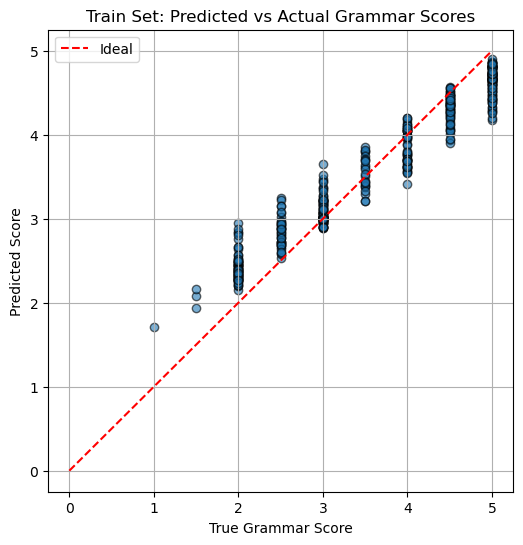

MSE: 0.11333457207207207
R² Score: 0.9084931020642202


In [151]:
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Predict on training data
y_true = train_df['label']
y_pred = model.predict(train_features)

# Scatter plot
plt.figure(figsize=(6, 6))
plt.scatter(y_true, y_pred, alpha=0.6, edgecolors='k')
plt.plot([0, 5], [0, 5], 'r--', label='Ideal')  # Diagonal line
plt.xlabel("True Grammar Score")
plt.ylabel("Predicted Score")
plt.title("Train Set: Predicted vs Actual Grammar Scores")
plt.grid(True)
plt.legend()
plt.show()

print("MSE:", mean_squared_error(y_true, y_pred))
print("R² Score:", r2_score(y_true, y_pred))

- The distribution is centered around zero which told that the predictions are unbiased overall.
- The bell shaped curve showed that there are errors but they are small .
- There are some errors in the range of +2 to -2.

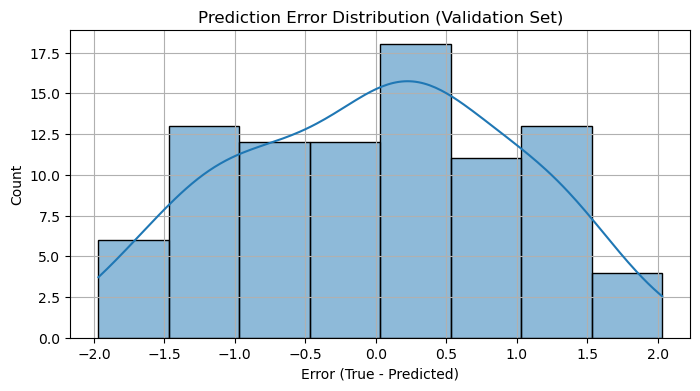

In [154]:
import seaborn as sns

errors = y_val - y_pred
plt.figure(figsize=(8, 4))
sns.histplot(errors, kde=True)
plt.title("Prediction Error Distribution (Validation Set)")
plt.xlabel("Error (True - Predicted)")
plt.ylabel("Count")
plt.grid(True)
plt.show()

#### This showed that the model didn't depend only on a single variable, but it identified various key features like spectral_1, spectral_4, etc. 

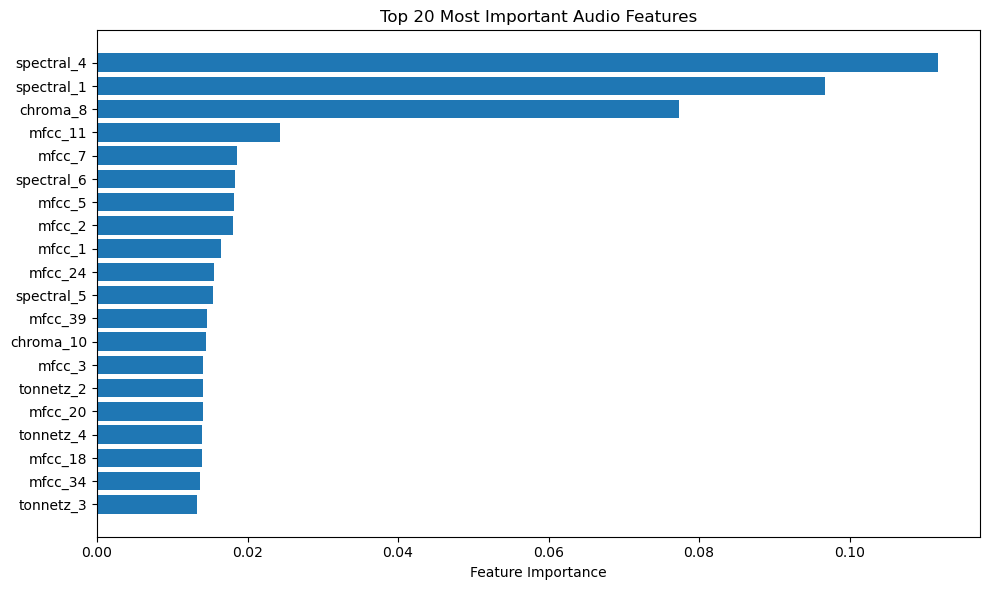

In [172]:
importances = model.feature_importances_
feature_names = [f"mfcc_{i+1}" for i in range(40)] + \
                [f"chroma_{i+1}" for i in range(12)] + \
                [f"spectral_{i+1}" for i in range(7)] + \
                [f"tonnetz_{i+1}" for i in range(6)]

indices = np.argsort(importances)[-20:]  # top 20
plt.figure(figsize=(10, 6))
plt.barh(np.array(feature_names)[indices], importances[indices])
plt.xlabel("Feature Importance")
plt.title("Top 20 Most Important Audio Features")
plt.tight_layout()
plt.show()

# SUMMARY

- We have dataset train.csv, test.csv, audio_test files, and audio_train files.
- Used Google Speech-to-Text API to transcribe the audio files into text form.
- Paired each of these transcriptions with their ground truth labels.
- Extracted various ranges of audio features like **MFCCs, Chrome, Spectral features, Tonnetz**
- Trained a RandomForestRegeressor, an ensemble method suitable for handling complex feature interactions.
- Gave a simple inference for the user or evaluator to upload an audio.wav file and receive a prediction score in between 0 to 5.
![Screenshot](images/ss1.png)

![Screenshot](images/ss5.png)

![Screenshot](images/ss4.png)

![Screenshot](images/ss3.png)


